## `Speculator`: NMF-based SFH with burst.

`speculator` takes physical parameters and predict PCA coeffs (see `PCA_components_NMF.ipynb`), spectra, and also magnitudes. 

This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import torch
from torch import Tensor
from scipy.stats import norm

In [3]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator

In [4]:
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=100)

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index, redshift

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

### Validate combined emulators

In [5]:
from popsed.speculator import SuperSpeculator

In [6]:
name = 'NMF_ZH'

In [7]:
params = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.{name}.v0.2.theta_unt.seedtest.npy')[:10000]
params = params[:, 1:]
# exclude stellar mass (1 M_\dot), remain redshift (i.e., length of SFH)
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')
print('Number of samples:', params.shape[0])

Number of samples: 10000


In [8]:
# slow
fspecs = [f'./train_sed_{name}/{name.lower()}_seds/fsps.{name}.v0.2.log10spectrum.seedtest.npy']
logspec = np.load(fspecs[0])[:10000]
logspec = logspec.astype('float32')
# logspec = logspec#[:, wave > 2000]

In [9]:
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh', 
                 'dust1', 'dust2', 
                 'dust_index', 'redshift'],  # , 'logm'
    device='cuda')

filters = ['sdss_{0}0'.format(b) for b in 'ugriz']

# noise = 'nsa'
# noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

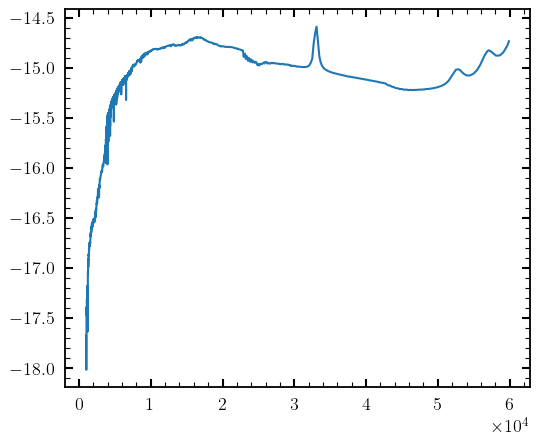

In [10]:
plt.plot(speculator.wavelength.cpu().numpy(), logspec[10])
# plt.xlim(1000, 8000)

In [17]:
speculator._predict_spec_with_mass_redshift(torch.Tensor(np.hstack([params, np.zeros((len(params), 1))])).to('cuda'),
                                            external_redshift=torch.zeros((len(params), 1)).to('cuda'))

tensor([[1.5019e-17, 1.2723e-17, 6.1675e-18,  ..., 1.5774e-15, 1.6697e-15,
         1.8392e-15],
        [2.1340e-16, 1.8533e-16, 9.9777e-17,  ..., 3.3816e-15, 3.6037e-15,
         4.0108e-15],
        [1.4013e-45, 7.0065e-45, 2.3822e-44,  ..., 1.2687e-15, 1.3412e-15,
         1.4744e-15],
        ...,
        [1.0000e-30, 1.0000e-30, 1.0000e-30,  ..., 8.1770e-16, 8.5697e-16,
         9.2888e-16],
        [8.9769e-19, 7.6822e-19, 3.7050e-19,  ..., 1.6357e-16, 1.7422e-16,
         1.9375e-16],
        [3.0628e-36, 6.9090e-36, 9.1822e-36,  ..., 8.6594e-16, 9.0407e-16,
         9.7396e-16]], device='cuda:0', grad_fn=<IndexPutBackward0>)

In [18]:
_specs = speculator._predict_spec_restframe(params).cpu().detach().numpy()

In [19]:
diff = 100 * (10**logspec - _specs) / 10**logspec

In [20]:
med_diff = np.nanmedian(diff, axis=0)
diff_1sigma = [np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(1) * 100, axis=0)]
diff_2sigma = [np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(2) * 100, axis=0)]

(90.0, 205.0)

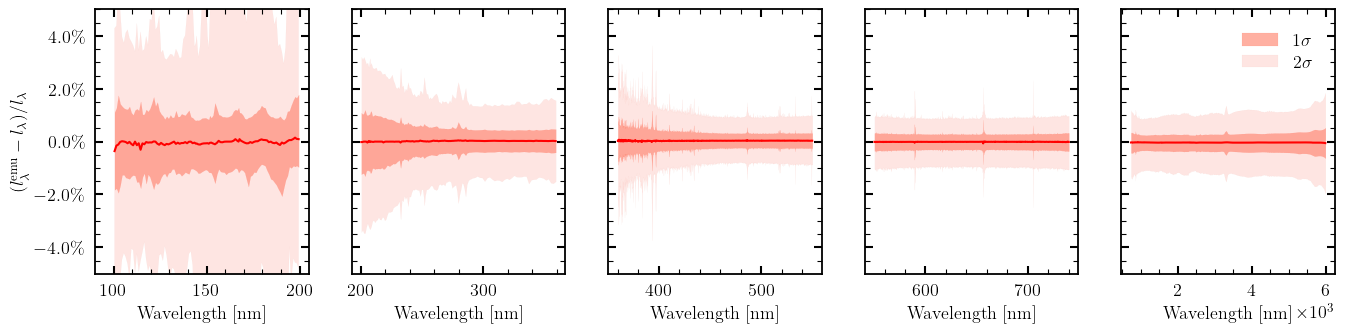

In [21]:
import matplotlib.ticker as mtick
fig, axes = plt.subplots(1, 5, figsize=(16, 3.5), sharey=True)

for i_bin in range(5):
    plt.sca(axes[i_bin])
    wave_bin = [ 
            (wave >= 1000) & (wave < 2000), 
            (wave >= 2000) & (wave < 3600), 
            (wave >= 3600) & (wave < 5500), 
            (wave >= 5500) & (wave < 7410), 
            (wave >= 7410) & (wave < 60000)
            ][i_bin]
    x = wave[wave_bin] / 10
    plt.plot(x, med_diff[wave_bin], color='r')
    plt.fill_between(x, 
                     diff_1sigma[0][wave_bin], 
                     diff_1sigma[1][wave_bin], 
                     alpha=0.5, lw=0.1, color='tomato', label='$1\sigma$')

    plt.fill_between(x, 
                     diff_2sigma[0][wave_bin], 
                     diff_2sigma[1][wave_bin], 
                     alpha=0.2, lw=0.1, color='salmon', label='$2\sigma$')
    plt.xlabel('Wavelength [nm]')
#     plt.ylim(-2.5, 2.5)
    plt.ylim(-5, 5)
    
axes[0].set_ylabel(r'$(l_{\lambda}^{\mathrm{emu}} - l_{\lambda})/l_{\lambda}$')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[-1].legend(loc='upper right')#, bbox_to_anchor=(-0.03, 1.))
axes[0].set_xlim(90, 205)

# plt.savefig('/home/jiaxuanl/Research/popsed/figure/speculator_accuracy.png')

### Test magnitude

In [8]:
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh', 
                 'dust1', 'dust2', 
                 'dust_index', 'redshift'],  # , 'logm'
    device='cuda')

filters = ['sdss_{0}0'.format(b) for b in 'ugriz']

# noise = 'nsa'
# noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [23]:
params

array([[ 0.43523106,  0.28521152,  0.88915629, ...,  1.91553432,
         0.74803122,  0.99438326],
       [ 0.5256601 ,  0.15345933,  0.58649492, ...,  0.99884958,
         0.99313343,  1.34438247],
       [ 0.26491222,  0.5299649 ,  0.47803023, ...,  0.70034334,
        -1.91283625,  0.1001333 ],
       ...,
       [ 0.75406041,  0.22964957,  0.91815578, ...,  0.59919216,
        -2.93103274,  0.18526378],
       [ 0.43549125,  0.32632142,  0.7255596 , ...,  1.31712496,
         0.36734796,  1.09064238],
       [ 0.89745522,  0.68055893,  0.14993805, ...,  2.05596585,
        -0.98995062,  0.01040288]])

In [26]:
_mags = speculator.predict_mag(params, filterset=[f'sdss_{ff}0' for ff in 'ugriz']).cpu().detach().numpy()

In [22]:
_mags = speculator._predict_mag_with_mass_redshift(
                              params,
#                               log_stellar_mass=None, 
#                               redshift=None, 
                              filterset=[f'sdss_{ff}0' for ff in 'ugriz']
                             ).cpu().detach().numpy()

TypeError: _predict_mag_with_mass_redshift() got an unexpected keyword argument 'log_stellar_mass'

In [27]:
_mags

array([[ 9.019228 ,  8.001231 ,  7.498779 ,  7.0769   ,  6.6403384],
       [ 6.26945  ,  5.5759816,  5.4353876,  5.303849 ,  5.2029066],
       [ 9.380087 ,  7.0648136,  6.089904 ,  5.6197   ,  5.260756 ],
       ...,
       [10.233611 ,  6.9055185,  5.675001 ,  5.1898737,  4.883619 ],
       [10.66867  ,  9.564873 ,  9.083696 ,  8.742601 ,  8.465529 ],
       [11.904851 ,  8.44195  ,  6.709832 ,  5.839013 ,  5.2566338]],
      dtype=float32)

In [28]:
# Use sedpy to calculate magnitudes on true spectra
from sedpy import observate
from popsed.models import lightspeed, to_cgs_at_10pc, jansky_cgs

In [29]:
filterset = observate.load_filters([f'sdss_{ff}0' for ff in 'ugriz'])
mags = np.zeros_like(_mags)
# mags = np.zeros((30000, 5))
for i, f in enumerate(filterset):
    mags[:, i] = f.ab_mag(wave, 10**logspec * lightspeed / wave**2 * to_cgs_at_10pc)

In [53]:
np.save('./train_sed_NMF/training_mags.npy', mags) # to compare with NSA colors

In [31]:
diff = 100 * (mags - _mags) / mags

In [32]:
med_diff = np.nanmedian(diff, axis=0)
diff_1sigma = [np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(1) * 100, axis=0)]
diff_2sigma = [np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(2) * 100, axis=0)]

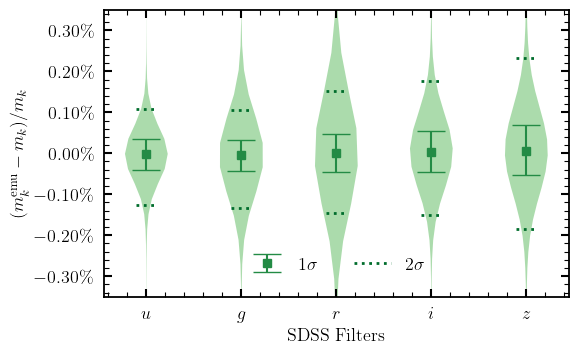

In [33]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(6, 3.8))

x = np.array([0, 1, 2, 3, 4])

plt.errorbar(x, med_diff, 
             yerr=[med_diff - diff_1sigma[0], 
                   diff_1sigma[1] - med_diff], 
             fmt='s', color='#238b45', capsize=10,
             label=r'$1\sigma$')
        
violin = plt.violinplot(diff, positions=x, 
                        showmedians=False, showextrema=False, 
                        quantiles=[[(1 - norm.cdf(2)), norm.cdf(2)] for i in range(5)],
                        widths=0.45,
                        points=1000
                       )
for pc in violin['bodies']:
    pc.set_facecolor('#74c476')
    pc.set_alpha(0.6)
violin['cquantiles'].set_color('#006d2c')
violin['cquantiles'].set_alpha(1.)
violin['cquantiles'].set_linestyle('dotted')
violin['cquantiles'].set_linewidth(2)
violin['cquantiles'].set_label(r'$2\sigma$')


ax.set_xticks(x)
ax.set_xticklabels([f'${ff}$' for ff in list('ugriz')])
ax.set_xlabel('SDSS Filters')
ax.set_ylabel(r'$(m_k^{\mathrm{emu}} - m_k) / m_k$')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='upper left', bbox_to_anchor=(-0.03, 1.))

plt.ylim(-0.35, 0.35)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           loc='lower center', ncol=2, frameon=False, 
           facecolor=None, shadow=False) 

# plt.savefig('/home/jiaxuanl/Research/popsed/figure/photulator_accuracy.png')

#### Try redshift

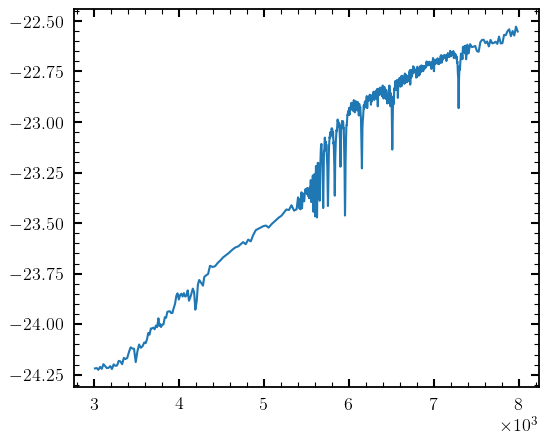

In [22]:
redshift_specs = torch.log10(speculator.predict_spec(params, 
                       log_stellar_mass=torch.ones(len(params), 1).to('cuda') * 10, 
                       redshift=torch.ones(len(params), 1).to('cuda') * 0.5))
flag = (speculator.wavelength < 8000) & (speculator.wavelength > 3000)
redshift_specs = redshift_specs[:, flag].cpu().detach().numpy()
plt.plot(speculator.wavelength[flag].cpu().numpy(), redshift_specs[5])